In [1]:
%run stdPackages.ipynb
from lpEnergyModels.mBasicInt import * # Load everything from the mBasicInt module

# Adjust/create new data for the `MBasicInt` model 

**Resources:** 
* The notebook docs/MBasicInt.ipynb contains documentation for the `MBasicInt` model.
* The excel file data/EX_MBasicInt_CA.xlsx contains a dataset consistent with the `MBasicInt` model. The file `data/EX_MBasicInt_CA.pkl` is a pickled version of the data obtained from applying `pyDbs.ExcelSymbolLoader` to read the file.
    - The dataset is constructed by the github copilot by asking for data that mimics the Californian electricity system.
    - It represents hourly variation using 24 hours to primarily capture the daily variation in demand and availability of intermittent energy.

**Short code for setting up model, adding data, solving:**

In [2]:
# 1. Initialize model
m = MBasicInt() # initialize model
# 2. Load data:
data = pyDbs.ExcelSymbolLoader(os.path.join(_d['data'],'EX_MBasicInt_CA.xlsx'))()
# 3. Add symbols to model database:
[m.db.__setitem__(k, v) for k,v in data.items() if k!='__meta__'];
# 4. Compile: Create model structure
m.compile()
# 5. Solve and add to model database.
m.postSolveToDB(m.solve())

### 1. New data scenario

*Queries for copilot agent: (1) Give it sufficient context, but not too much (overload), to do the task e.g. for data/model structure. (2) Give it plenty of prompts for descriptions and checks to make. It is pretty good at troubleshooting and refining its answers.*

**Example: Create new data scenario.**

* *Description*: Create a dataset for the `MBasicInt` model that mimics the Danish electricity system in 2025. Find realistic estimates to use for fuel prices, variable and operating costs for different technology types, and fixed and investment costs for different technologies. Find realistic hourly variation in demand and generation patterns to match price variation in the Danish electricity market.
* *Context*: Try to give none - the default instructions should be enough; we do not want overload.
* *Validation*: Try to give none for now; default instructions may be enough.

Manual validation test:

In [3]:
dataDK = pyDbs.ExcelSymbolLoader(os.path.join(_d['data'], 'EX_MBasicInt_DK2025.xlsx'))()
mDK = MBasicInt()
[mDK.db.__setitem__(k, v) for k,v in dataDK.items() if k!='__meta__'];
# 4. Compile: Create model structure
mDK.compile()
# 5. Solve and add to model database.
mDK.postSolveToDB(mDK.solve())

*Follow-up (if you want to use this data going forward):* Write a short README file in the `data` folder that briefly describes the dataset. It serves as documentation for copilot and/or human programmer to load and use later on.

### 2. Expand hourly set

**Example (follow-up):** To get a more realistic price variation and capture the potential balancing issues, expand the dataset to include 8760 hours of the year. Once again, try and taylor the data to capture the Danish setup

Manual validation test:

In [4]:
dataDKFull= pyDbs.ExcelSymbolLoader(os.path.join(_d['data'], 'EX_MBasicInt_DK2025_8760.xlsx'))()
mDKFull = MBasicInt()
[mDKFull.db.__setitem__(k, v) for k,v in dataDKFull.items() if k!='__meta__'];
# 4. Compile: Create model structure
mDKFull.compile()
# # 5. Solve and add to model database.
mDKFull.postSolveToDB(mDKFull.solve())

Sorted prices across a year:

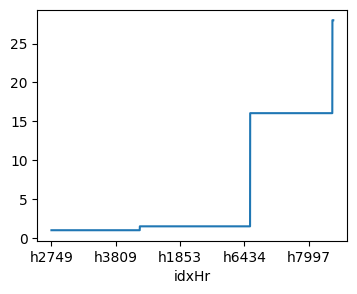

In [5]:
mDKFull.db('pHr').sort_values().plot(figsize=(4,3));

### 3. Experiment to obtain more realistic prices

**Example (follow-up):** 

* *Description:* We want to be able to produce realistic hourly variation in prices throughout a year. One obvious issue with the current setup is that peak generators are never really active, and the prices are almost always set by one of the renewable generators (with prices around 1-1.5€/GJ). Let us try to get closer to observed price patterns by experimenting with: (1) The hourly variation for generators' production throughout a year, (2) the set of consumers and their willingness to pay. Actual prices in the day ahead market can be found at website "energidataservice.dk".
* *Context (is likely not needed):* The following routine can be used to update model data in `MBasicInt` model instance `m` from dictionary of data `data` and solve to inspect the effect on prices:
```python
[m.db.__setitem__(k,v) for k,v in data.items() if k !='__meta__']; # used for updating database with data being a dictionary of pandas symbols
m.compile() # update coefficients in LP system
m.postSolveToDB(m.solve()) # add to solution to model database
m.db('pHr') # get hourly prices
```

*Suggested result:*

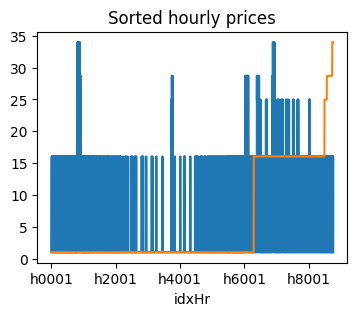

In [6]:
dataExp = pyDbs.ExcelSymbolLoader(os.path.join(_d['data'],'EX_MBasicInt_DK2025_8760_exp.xlsx'))()
mExp = MBasicInt()
[mExp.db.__setitem__(k,v) for k,v in dataExp.items() if k!='__meta__']
mExp.compile()
mExp.postSolveToDB(mExp.solve())
mExp.db('pHr').plot(figsize=(10,2))
mExp.db('pHr').sort_values().reset_index(drop=True).plot(figsize=(4,3), title='Sorted hourly prices');

**Example (follow-up):** 

* *Description:* Generate a helper script that extracts data series for observed electricity prices in Denmark from https://www.energidataservice.dk/datasets. Prepare the dataset with the goal of comparing model outcomes to observed prices in DK1/DK2. Provide a snippet of code that applies the helper script to load in relevant data.

Fetched 8760/8760 initial records
Observed quantiles (€/GJ):
0.05     0.005556
0.10     2.777778
0.25    11.294444
0.50    18.891667
0.75    26.440277
0.90    33.351111
0.95    38.505278
0.99    59.006723
Name: SpotPriceGJ, dtype: float64

Model quantiles (€/GJ):
0.05     1.00
0.10     1.00
0.25     1.00
0.50     1.00
0.75    16.05
0.90    16.05
0.95    16.05
0.99    28.72
Name: equilibrium, dtype: float64

Calibration suggestions:
- Scarcity too low: reduce natgas or raise natgas_peak VOM by +10%.
- Low-price tail missing: increase renewable variability or allow negative pricing (e.g., subsidy).

Stored calibration artifacts in variable db_calib.

Stored calibration artifacts in variable db_calib.


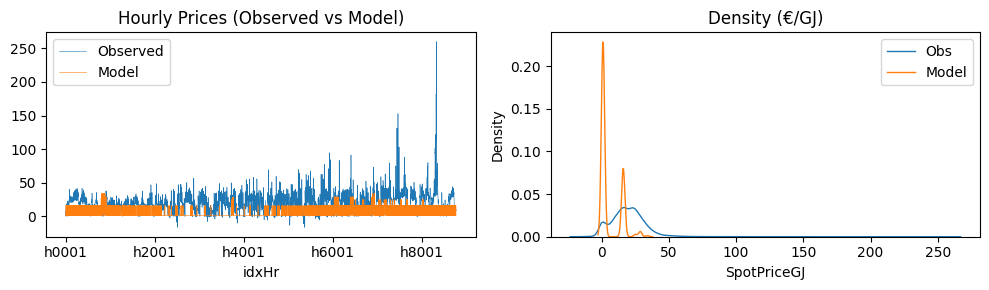

In [7]:
# Calibration helper: Fetch observed DK1 prices, compare with model, heuristic adjust
import os, pandas as pd
from scripts.fetch_prices import (
    fetch_elspot_prices, collapse_dst, prepare_model_hours, price_quantiles
)

# --- Parameters ---
obs_start = '2024-01-01'
obs_end   = '2024-12-31'
obs_area  = 'DK1'

# Choose which model instance to compare (mDKFull, mExp, etc.)
model_instance = locals().get('mExp', locals().get('mDKFull'))  # prefer experimental if exists
if model_instance is None:
    raise RuntimeError("No model instance named mExp or mDKFull found. Run model earlier in notebook.")

# Fetch observed prices
obs_df = fetch_elspot_prices(obs_start, obs_end, areas=(obs_area,), verbose=True)
obs_df = collapse_dst(obs_df)
obs_series = prepare_model_hours(obs_df, area=obs_area, value_col='SpotPriceGJ')

# Align lengths if model shorter/longer (truncate to min length)
model_prices = model_instance.db('pHr').copy()
if len(model_prices) != len(obs_series):
    n = min(len(model_prices), len(obs_series))
    model_prices = model_prices.iloc[:n]
    obs_series   = obs_series.iloc[:n]

# --- Quantile comparison ---
qs = [0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]
obs_q = obs_series.quantile(qs)
mod_q = model_prices.quantile(qs)
print('Observed quantiles (€/GJ):')
print(obs_q)
print('\nModel quantiles (€/GJ):')
print(mod_q)

# --- Simple heuristic adjustment proposal (no automatic re-solve here) ---
# Rules:
# 1. If model 95th < 0.9 * observed 95th -> suggest reducing natgas capacity by 10% or increasing peaker VOM +10%.
# 2. If model median > observed median * 1.1 -> suggest adding 5% wind_offshore capacity.
# 3. If model 5th percentile > observed 5th percentile * 1.5 -> suggest increasing solar variability or adding must-run low-cost hours.

suggestions = []
if mod_q.loc[0.95] < 0.9 * obs_q.loc[0.95]:
    suggestions.append('Scarcity too low: reduce natgas or raise natgas_peak VOM by +10%.')
if mod_q.loc[0.50] > 1.1 * obs_q.loc[0.50]:
    suggestions.append('Median too high: consider adding 5% wind_offshore capacity or lowering gas fuel price.')
if mod_q.loc[0.05] > 1.5 * obs_q.loc[0.05]:
    suggestions.append('Low-price tail missing: increase renewable variability or allow negative pricing (e.g., subsidy).')

print('\nCalibration suggestions:')
if suggestions:
    for s in suggestions:
        print('-', s)
else:
    print('Model price distribution broadly aligned; no immediate heuristic adjustment suggested.')

# (Optional) quick visualization if matplotlib available
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    obs_series.plot(ax=ax[0], lw=0.4, label='Observed')
    model_prices.plot(ax=ax[0], lw=0.4, label='Model')
    ax[0].set_title('Hourly Prices (Observed vs Model)')
    ax[0].legend()
    sns.kdeplot(obs_series, ax=ax[1], label='Obs', lw=1)
    sns.kdeplot(model_prices, ax=ax[1], label='Model', lw=1)
    ax[1].set_title('Density (€/GJ)')
    ax[1].legend()
    plt.tight_layout()
except Exception as e:
    print('Plot skipped:', e)

# Store for later referencing
db_calib = {
    'obs_prices': obs_series,
    'model_prices': model_prices,
    'obs_quantiles': obs_q,
    'model_quantiles': mod_q,
    'suggestions': suggestions
}
print('\nStored calibration artifacts in variable db_calib.')

### 4. Calibration: Match Model Prices to Observed DK1 Spot Prices

This section fetches observed DK1 day-ahead prices (€/GJ), compares distributional statistics with the model scenario, and applies a very simple capacity / peaker cost adjustment heuristic to narrow gaps.

Steps:
1. Fetch prices for selected year.
2. Generate quantiles vs model (`pHr`).
3. If model 95th percentile < observed 95th → increase scarcity by reducing main gas capacity or raising peaker VOM.
4. If model median > observed median → lower marginal costs (e.g., reduce gas price placeholder) or increase renewable capacity.
5. (Optional) Iterate a few loops.

Heuristic is intentionally lightweight; refine manually after reviewing results.